<a href="https://colab.research.google.com/github/hello-ram/hw2/blob/master/Week_2_Make_Money_with_Machine_Learning_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import all of the necessary packages we need, which include NumPy, Pandas, Matplotlib, Scikit-learn and Keras/Tensorflow.

In [1]:
# Import necessary packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD

Using TensorFlow backend.


I have exported the Tesla stock price data to my personal Dropbox and will be downloading it locally.

In [2]:
# Download the data and store it
# Tesla stock since the beginning
!wget -O tesla.csv https://www.dropbox.com/s/na2vurooejpew59/TSLA.csv?dl=1

--2019-09-16 01:38:05--  https://www.dropbox.com/s/na2vurooejpew59/TSLA.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.1, 2620:100:6031:1::a27d:5101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/na2vurooejpew59/TSLA.csv [following]
--2019-09-16 01:38:05--  https://www.dropbox.com/s/dl/na2vurooejpew59/TSLA.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb4cfd729ccc7702c97a85f8eb0.dl.dropboxusercontent.com/cd/0/get/Aoq_ju7wMQ__fHZrP0U1vTZBp74MEp4VcvWOgHbN-N2dZCsGgslrAlJR1oBrnhwmW322yttHtAt2VsfpPwiFaEmc4Brbkn4ebqA9MLRlxzc6eNwAQGdeNEIPXIykA5pYOAs/file?dl=1# [following]
--2019-09-16 01:38:06--  https://ucb4cfd729ccc7702c97a85f8eb0.dl.dropboxusercontent.com/cd/0/get/Aoq_ju7wMQ__fHZrP0U1vTZBp74MEp4VcvWOgHbN-N2dZCsGgslrAlJR1oBrnhwmW322yttHtAt2VsfpPwiFaEmc4Brbkn4ebqA9MLRlxzc6eNwAQGdeNEIPX

Use Pandas to read in the data and set the independent variable to be the *Date*.  Let's also take a look at the first few entries

In [0]:
df = pd.read_csv('tesla.csv')

In [6]:
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


Let's take a look at how the prices looks like each day since the beginning up to this point with the date on the x-axis and the price on the y-axis.

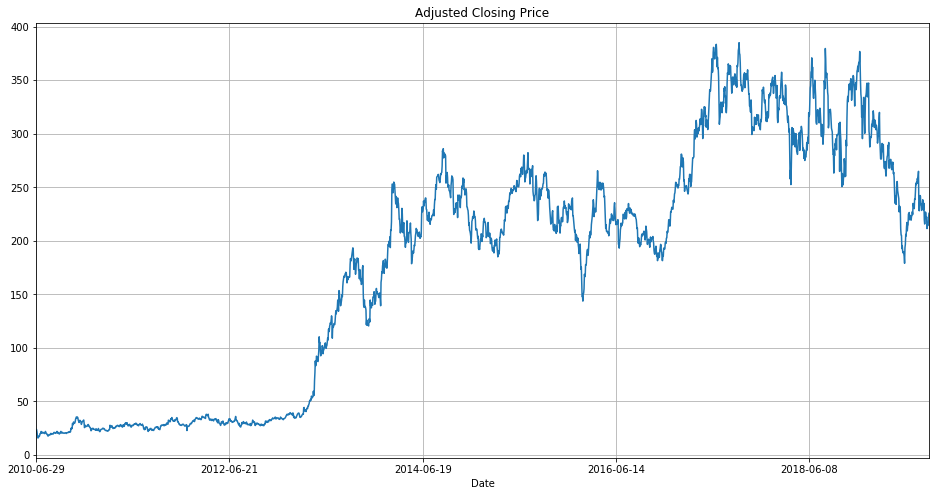

In [7]:
df['Adj Close'].plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

To make this more robust to noise and to leverage past values, we will not use the date to predict the stock prices, but we will use batches of 32 prices where each training example, we leverage 32 prices from the past to predict the price on the 33rd day.  We will thus have $N - 32$ training examples with $N$ being the number of days we've downloaded for the stock data.  We will thus create a 2D matrix of training samples with each row being the prices 32 consecutive days in the past with the price to predict being the current day.

In [0]:
window_size = 32 # Allow us to look at 32 days into the past
# Prepare the data so that we have 32 day windows and predict what the next day should be

# Get indices of access for the data
num_samples = len(df) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)

In [0]:
data = df['Adj Close'].values[indices] # Create the 2D matrix of training samples

We create a 2D matrix such that we have 33 columns per example.  The training samples will be the first 32 columns with the target variable being the last column.

In [0]:
X = data[:,:-1] # Each row represents 32 days in the past
y = data[:,-1] # Each output value represents the 33rd day

In [11]:
print(X)

[[ 23.889999  23.83      21.959999 ...  19.030001  17.9       17.6     ]
 [ 23.83      21.959999  19.200001 ...  17.9       17.6       18.32    ]
 [ 21.959999  19.200001  16.110001 ...  17.6       18.32      18.780001]
 ...
 [253.5      252.380005 254.860001 ... 211.399994 215.       214.080002]
 [252.380005 254.860001 253.539993 ... 215.       214.080002 215.589996]
 [254.860001 253.539993 258.179993 ... 214.080002 215.589996 221.710007]]


In [0]:
print(y)

Perform train/test split such that the first 80% of the prices is the training set and the last 20% of the prices is the test dataset.  We will train on the training set and test the performance on the test set to see how well we can forecast the price for Tesla stock.

In [0]:
# Train and test split
split_fraction = 0.8
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]

# Method #1 - Ridge Regression

We will use the Ridge Regression method from Scikit-learn where we'll train and perform inference on the training and test data respectively.  Let's also plot how it compares with the actual data for both training and test.

In [0]:
# Train
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Infer
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_ridge = ridge_model.predict(X_test)

In [34]:
df_ridge =df.copy()
print(df_ridge)

                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2010-06-29   19.000000   25.000000  ...   23.889999  18766300
2010-06-30   25.790001   30.420000  ...   23.830000  17187100
2010-07-01   25.000000   25.920000  ...   21.959999   8218800
2010-07-02   23.000000   23.100000  ...   19.200001   5139800
2010-07-06   20.000000   20.000000  ...   16.110001   6866900
2010-07-07   16.400000   16.629999  ...   15.800000   6921700
2010-07-08   16.139999   17.520000  ...   17.459999   7711400
2010-07-09   17.580000   17.900000  ...   17.400000   4050600
2010-07-12   17.950001   18.070000  ...   17.049999   2202500
2010-07-13   17.389999   18.639999  ...   18.139999   2680100
2010-07-14   17.940001   20.150000  ...   19.840000   4195200
2010-07-15   19.940001   21.500000  ...   19.889999   3739800
2010-07-16   20.700001   21.299999  ...   20.639999   2621300
2010-07-19   21.370001   22.250000  ...   21.910000   2486500
2010-07-

In [35]:
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
print(df_ridge)

             Adj Close
Date                  
2010-06-29   23.889999
2010-06-30   23.830000
2010-07-01   21.959999
2010-07-02   19.200001
2010-07-06   16.110001
2010-07-07   15.800000
2010-07-08   17.459999
2010-07-09   17.400000
2010-07-12   17.049999
2010-07-13   18.139999
2010-07-14   19.840000
2010-07-15   19.889999
2010-07-16   20.639999
2010-07-19   21.910000
2010-07-20   20.299999
2010-07-21   20.219999
2010-07-22   21.000000
2010-07-23   21.290001
2010-07-26   20.950001
2010-07-27   20.549999
2010-07-28   20.719999
2010-07-29   20.350000
2010-07-30   19.940001
2010-08-02   20.920000
2010-08-03   21.950001
2010-08-04   21.260000
2010-08-05   20.450001
2010-08-06   19.590000
2010-08-09   19.600000
2010-08-10   19.030001
...                ...
2019-07-22  255.679993
2019-07-23  260.170013
2019-07-24  264.880005
2019-07-25  228.820007
2019-07-26  228.039993
2019-07-29  235.770004
2019-07-30  242.259995
2019-07-31  241.610001
2019-08-01  233.850006
2019-08-02  234.339996
2019-08-05 

In [36]:
df_ridge = df_ridge.iloc[window_size:ind_split]

print(df_ridge)

             Adj Close
Date                  
2010-08-13   18.320000
2010-08-16   18.780001
2010-08-17   19.150000
2010-08-18   18.770000
2010-08-19   18.790001
2010-08-20   19.100000
2010-08-23   20.129999
2010-08-24   19.200001
2010-08-25   19.900000
2010-08-26   19.750000
2010-08-27   19.700001
2010-08-30   19.870001
2010-08-31   19.480000
2010-09-01   20.450001
2010-09-02   21.059999
2010-09-03   21.049999
2010-09-07   20.540001
2010-09-08   20.900000
2010-09-09   20.709999
2010-09-10   20.170000
2010-09-13   20.719999
2010-09-14   21.120001
2010-09-15   21.980000
2010-09-16   20.940001
2010-09-17   20.230000
2010-09-20   21.059999
2010-09-21   20.770000
2010-09-22   19.870001
2010-09-23   19.559999
2010-09-24   20.100000
...                ...
2017-08-10  355.399994
2017-08-11  357.869995
2017-08-14  363.799988
2017-08-15  362.329987
2017-08-16  362.910004
2017-08-17  351.920013
2017-08-18  347.459991
2017-08-21  337.859985
2017-08-22  341.350006
2017-08-23  352.769989
2017-08-24 

In [0]:
df_ridge['Adj Close Train'] = y_pred_train_ridge[:-window_size]



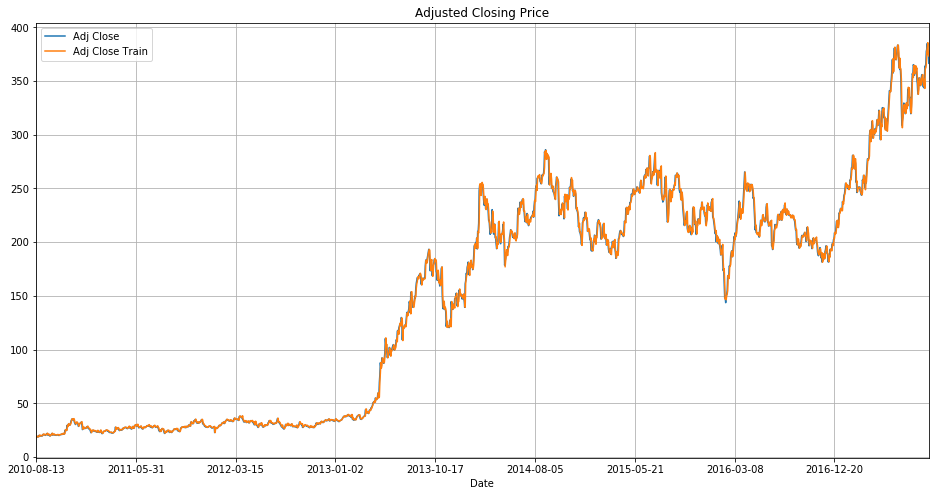

In [38]:
# Plot what it looks like for the training data
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_ridge['Adj Close Train'] = y_pred_train_ridge[:-window_size]
df_ridge.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

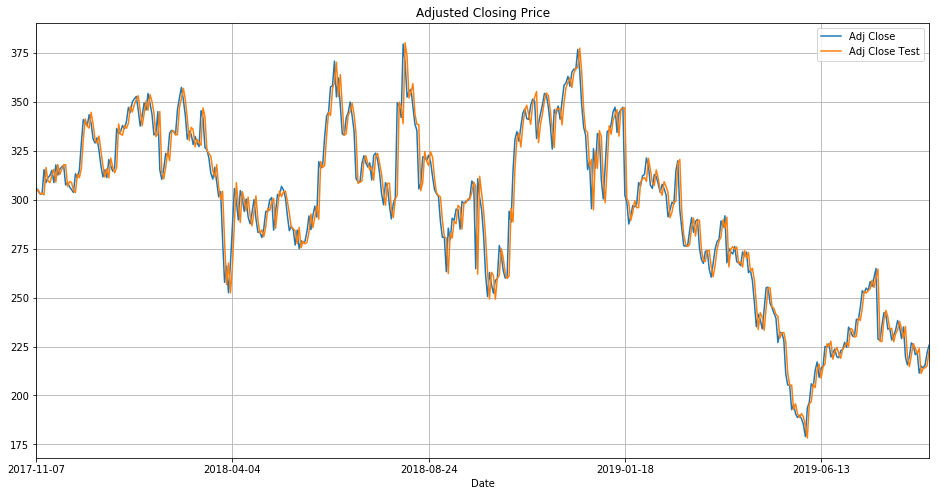

In [39]:
# Same for the test
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_ridge['Adj Close Test'] = y_pred_ridge
df_ridge.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

Wow... ok let's move on.

# Method #2 - Gradient Boosting Trees

Let's apply the same methodology from Method #1 to Gradient Boosting Trees in Scikit-learn.

In [0]:
# Model #2 - Gradient Boosting Trees
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Infer
y_pred_train_gb = gb_model.predict(X_train)
y_pred_gb = gb_model.predict(X_test)


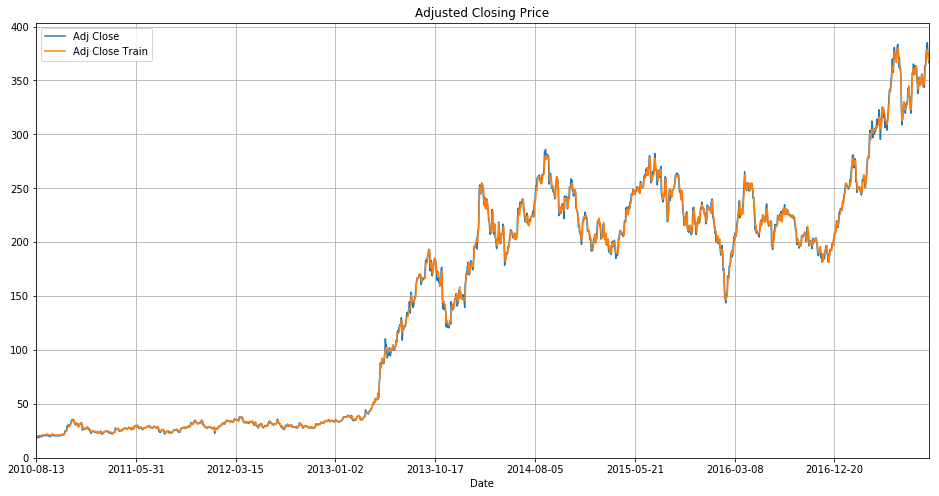

In [41]:
# Plot what it looks like for the training data
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_gb['Adj Close Train'] = y_pred_train_gb[:-window_size]
df_gb.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

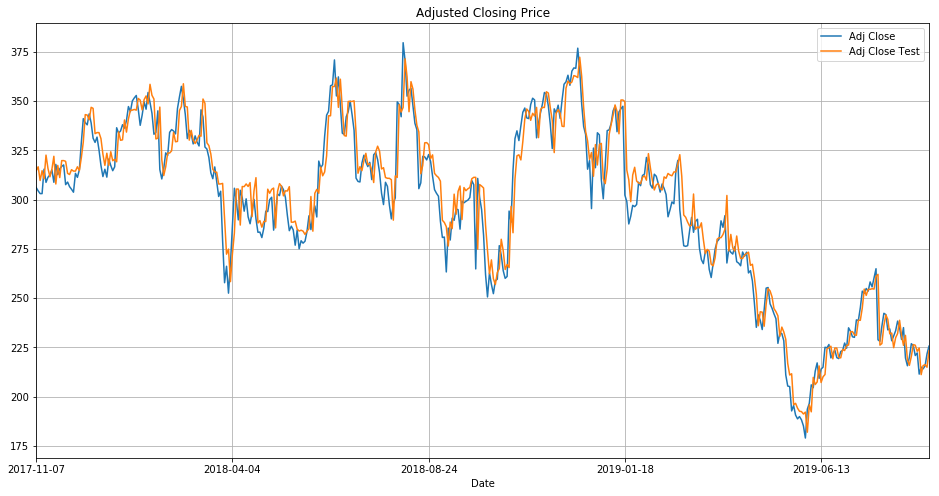

In [42]:
# Same for the test
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_gb['Adj Close Test'] = y_pred_gb
df_gb.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

The results here make sense.  Since trees performing majority voting so there's no interpolation involved, we can see at points of high curvature, it doesn't do so well but the general trend is correct.

# Method #3 - Using neural networks with 1D convolutional and LSTM layers

The last method we'll use is a neural network based one using Keras / Tensorflow.  We use a stack of Conv1D and LSTM layers, followed by Dense layers lastly followed by a linear layer to predict the stock price.

In [43]:
# Model #3 - Using RNNs
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])

keras_model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 32, 128)           768       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 128)           82048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)             

This is a technique to find the optimal learning rate for the neural network.  Specifically we gradually increase the learning rate at each epoch, recording the loss for each then choosing the learning rate that has the smallest loss overall.

Also, neural networks learn better when the data is normalized so we will normalize the data to the $[-1,1]$ range by using Scikit-learn's `MinMaxScaler`.  Therefore, we need to find apply this scaling on all of the price data, then decompose it into the training and test sets again.

In [44]:
# First figure out the right learning rate
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
# Scale the data due to LSTM units
scaler = MinMaxScaler(feature_range=(-1, 1))
data_transform = scaler.fit_transform(df['Adj Close'].values[:,None])
data_transform = data_transform[indices]
X2 = data_transform[:,:-1]
y2 = data_transform[:,-1]
X_train_reshape = X2[:ind_split]
y_train_reshape = y2[:ind_split]
X_test_reshape = X2[ind_split:]
y_test_reshape = y2[ind_split:]

We now try and find the optimal learning rate.  If you're using Google Colab, this will take ~4 minutes.

In [45]:
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, callbacks=[lr_schedule], validation_data=(X_test_reshape, y_test_reshape))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1822 samples, validate on 456 samples
Epoch 1/250
1822/1822 [==============================] - 10s 6ms/step - loss: 0.1318 - mean_absolute_error: 0.4157 - val_loss: 0.1093 - val_mean_absolute_error: 0.4242
Epoch 2/250
1822/1822 [==============================] - 1s 466us/step - loss: 0.1318 - mean_absolute_error: 0.4157 - val_loss: 0.1093 - val_mean_absolute_error: 0.4242
Epoch 3/250
1822/1822 [==============================] - 1s 454us/step - loss: 0.1318 - mean_absolute_error: 0.4157 - val_loss: 0.1093 - val_mean_absolute_error: 0.4242
Epoch 4/250
1822/1822 [==============================] - 1s 454us/step - loss: 0.1318 - mean_absolute_error: 0.4157 - val_loss: 0.1093 - val_mean_absolute_error: 0.4242
Epoch 5/250
1822/1822 [==============================] - 1s 453us/step - loss: 0.1318 - mean_absolute_error: 0.4157 - val_loss: 0.1093 - val_mean_absolute_error: 0.4242
Epoch 6/250
1

Let's plot the loss for the testing data versus the learning rate.  We can see that it explodes past a learning rate of 1, so let's focus our window to before this point.

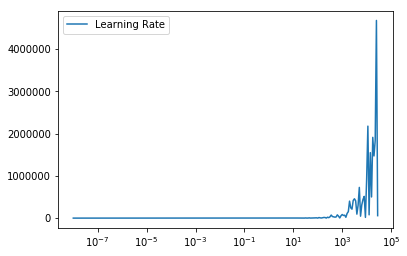

In [46]:
plt.semilogx(history.history['lr'], history.history['val_loss'])
plt.legend(['Learning Rate', 'Validation Loss'])

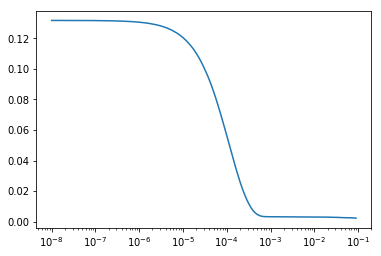

In [47]:
plt.semilogx(history.history['lr'][:140], history.history['loss'][:140])

It looks like the learning rate of 0.1 seems to work the best.  Let's use that learning rate and train the network this time for real.  Once we train the network, let's predict the prices for the training and test data.

In [48]:
# Observing the above graph, 0.1 seems to be the best learning rate
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])


optimizer = SGD(lr=0.1, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, validation_data=(X_test_reshape, y_test_reshape))

Train on 1822 samples, validate on 456 samples
Epoch 1/250
1822/1822 [==============================] - 2s 1ms/step - loss: 0.0861 - mean_absolute_error: 0.3318 - val_loss: 0.0375 - val_mean_absolute_error: 0.2449
Epoch 2/250
1822/1822 [==============================] - 1s 451us/step - loss: 0.0251 - mean_absolute_error: 0.1894 - val_loss: 0.0179 - val_mean_absolute_error: 0.1541
Epoch 3/250
1822/1822 [==============================] - 1s 464us/step - loss: 0.0114 - mean_absolute_error: 0.1194 - val_loss: 0.0148 - val_mean_absolute_error: 0.1436
Epoch 4/250
1822/1822 [==============================] - 1s 447us/step - loss: 0.0076 - mean_absolute_error: 0.0940 - val_loss: 0.0082 - val_mean_absolute_error: 0.1027
Epoch 5/250
1822/1822 [==============================] - 1s 451us/step - loss: 0.0047 - mean_absolute_error: 0.0719 - val_loss: 0.0116 - val_mean_absolute_error: 0.1190
Epoch 6/250
1822/1822 [==============================] - 1s 466us/step - loss: 0.0037 - mean_absolute_error: 0

Once we predict the values, we also must *reverse* the normalization so that we can plot the predictions in the same scale as the original values.

In [0]:
y_pred_train_keras = scaler.inverse_transform(keras_model.predict(X_train_reshape, batch_size=256))
y_pred_keras = scaler.inverse_transform(keras_model.predict(X_test_reshape, batch_size=256))

Let's now plot what the training and test predictions look like and compare witht he original values.

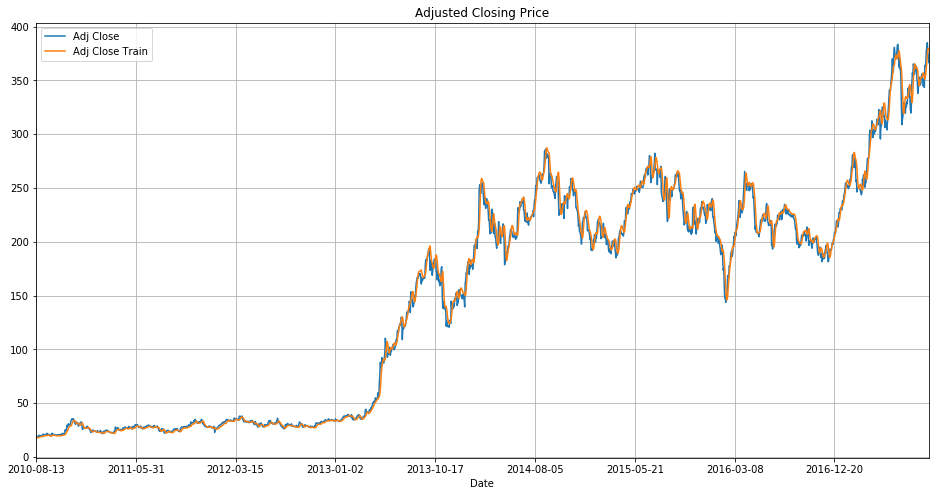

In [50]:
# Plot what it looks like for the training data
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_keras['Adj Close Train'] = y_pred_train_keras[:-window_size]
df_keras.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

Again, quite accurate... and now for the test data.

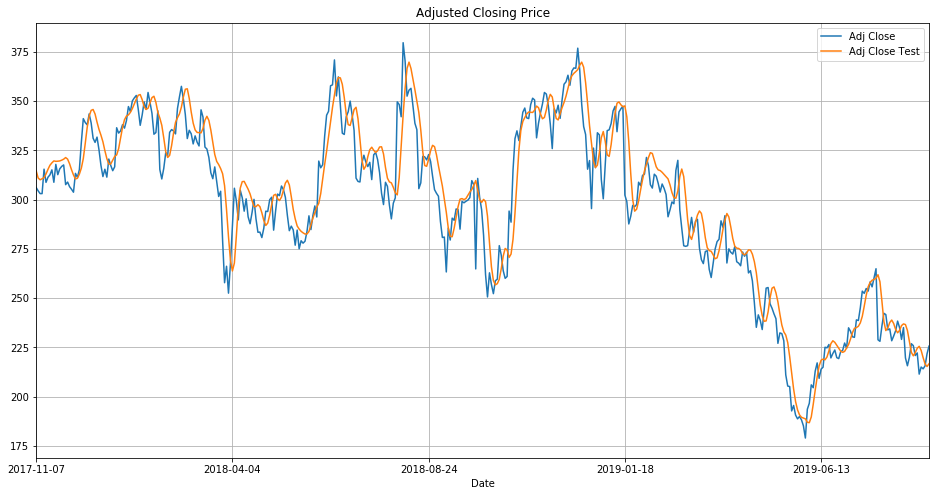

In [51]:
# Same for the test
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_keras['Adj Close Test'] = y_pred_keras
df_keras.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

I have more confidence in the neural network approach as it seems to indicate would the trend would be like when the data is noise free.  We can also see a more smoother transition between points of high curvature.

Finally to see how everything performs, let's plot all of the methods together for both the training and testing data.

In [0]:
df_train = df.copy()
df_train.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_train = df_train.iloc[window_size:ind_split] # Past 32 days we don't know yet
# Add in all of our methods
df_train['Adj Close Train Ridge'] = y_pred_train_ridge[:-window_size]
df_train['Adj Close Train Gradient Boosting'] = y_pred_train_gb[:-window_size]
df_train['Adj Close Train LSTM'] = y_pred_train_keras[:-window_size]
# Plot the data now
df_train.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)



Cool.  They all more or less follow the same trend... and now for the testing data.

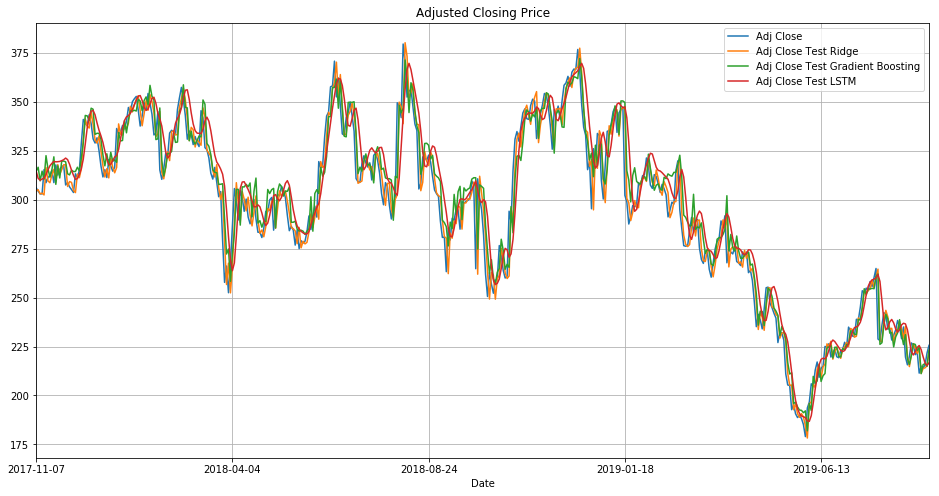

In [53]:
df_test = df.copy()
df_test.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_test = df_test.iloc[ind_split+window_size:] # Past 32 days we don't know yet
# Add in all of our methods
df_test['Adj Close Test Ridge'] = y_pred_ridge
df_test['Adj Close Test Gradient Boosting'] = y_pred_gb
df_test['Adj Close Test LSTM'] = y_pred_keras
# Plot the data now
df_test.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)



So here's where it gets interesting.  We can see that the neural network based method is what the values would be when there's no presence of noise.  The ridge regression based method seems to follow the trend the best with the noise modelled in.  The gradient boosting method also follows the same trend, but because the method does not use interpolation, points of very high curvature tend to be the most inaccurate.

# So what happens if we don't have testing data to try out?

Good question.  What you can do take the learned model that you have, then start with the last $N$ values in your data (in my case 32), and start predicting what the next values will be.  With the next values, keep using the previous $N$ values for your desired forecasting.

We already have our learned models above, so let's go ahead and do that.

In [0]:
num_days = 10 # Let's try and forecase the next 10 days or two years

# Get the last window_size (32) days
data_seed = df['Adj Close'].values[-window_size:][None]
# Get the normalized data as well for the neural network
data_seed_norm = scaler.transform(data_seed)
input_values = {"ridge": data_seed, "gb": data_seed, "keras": data_seed_norm.copy()}
values = {"ridge": [], "gb": [], "keras": []}
for i in range(num_days): # For each day...
    # Predict the next price given the previous N prices
    values["ridge"].append(ridge_model.predict(input_values["ridge"])[0])
    values["gb"].append(gb_model.predict(input_values["gb"])[0])
    values["keras"].append(keras_model.predict(input_values["keras"][...,None])[0][0])

    # Dump the oldest price and put the newest price at the end
    for v in input_values:
        val = input_values[v]
        val = np.insert(val, -1, values[v][-1], axis=1)
        val = np.delete(val, 0, axis=1)
        input_values[v] = val.copy()

# Convert all to NumPy arrays
for v in input_values:
    values[v] = np.array(values[v])

# Unnormalize prices from NN approach
values["keras"] = scaler.inverse_transform(values["keras"][None])[0]
    

Now let's plot the next 10 days worth of data

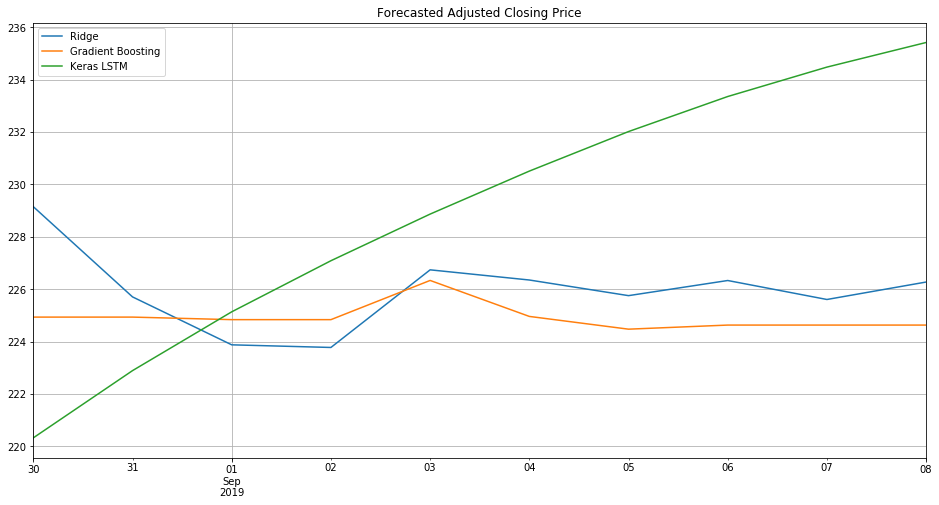

In [55]:
from datetime import timedelta, datetime
last_date = datetime.strptime(df.index[-1], '%Y-%m-%d')
df_forecast = pd.DataFrame()
df_forecast["Ridge"] = values["ridge"]
df_forecast["Gradient Boosting"] = values["gb"]
df_forecast["Keras LSTM"] = values["keras"]
df_forecast.index = pd.date_range(start=last_date, periods=num_days)
df_forecast.plot(label='TSLA', figsize=(16,8), title='Forecasted Adjusted Closing Price', grid=True)